In [1]:
### Compare the wind power input betweeb using both SD and buoy wind (on buoy's hourly grid)
# use buoy wind -- the goal is to see if the major difference is from current
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import sys
from numpy.linalg import norm
from scipy.interpolate import interp1d
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from convert_dir import vector_dir_to_from
from mystats import bandpass

In [16]:
### data info
year = '2023'
platf_num = '1042'
buoy_id = '42022'
lat_buoy = 27.505
fn_SD_hr_grid = 'timeseries_SD_wind-power-input_on-buoy-cur-grid_2023101912Z-111523Z.txt'
fn_buoy_hr_grid = 'timeseries_buoy_wind-power-input_on-cur-grid_2023101912Z-111523Z.txt'
### settings
tlim_plot = [datetime.datetime(int(year),10,23), datetime.datetime(int(year),10,31)] ### 2023 SD1042
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
### load data
### read as string to convert datetime array 
dataIN_SD = np.genfromtxt(fn_SD_hr_grid, skip_header=1, dtype=str)
dataIN_buoy = np.genfromtxt(fn_buoy_hr_grid, skip_header=1, dtype=str)
dtime_SD_grid = np.array([datetime.datetime.strptime(dataIN_SD[i,0]+' '+dataIN_SD[i,1],'%Y-%m-%d %H:%M:%S') for i in range(dataIN_SD.shape[0])])
dtime_buoy_grid = np.array([datetime.datetime.strptime(dataIN_buoy[i,0]+' '+dataIN_buoy[i,1],'%Y-%m-%d %H:%M:%S') for i in range(dataIN_buoy.shape[0])])
timestamp_SD_grid = np.array([dtime_SD_grid[i].timestamp() for i in range(len(dtime_SD_grid))])
timestamp_buoy_grid = np.array([dtime_buoy_grid[i].timestamp() for i in range(len(dtime_buoy_grid))])
### read as float for other columns
dataIN_SD = np.genfromtxt(fn_SD_hr_grid, skip_header=1, dtype=float)
dataIN_buoy = np.genfromtxt(fn_buoy_hr_grid, skip_header=1, dtype=float)

In [4]:
### band pass current velocity to NI band
dsec_buoy = (dtime_buoy_grid[1]-dtime_buoy_grid[0]).total_seconds() # buoy current's time interval in seconds
f_buoy = 2*(2*np.pi/86400)*np.sin(lat_buoy/180*np.pi) # 1/s
n_f = np.array([0.8,1.2])
f_bp = f_buoy*n_f
ucur_buoy_grid_bp = np.nan*np.ones( (dataIN_buoy.shape[0],) )
vcur_buoy_grid_bp = ucur_buoy_grid_bp.copy()
ucur_SD_grid_bp = ucur_buoy_grid_bp.copy()
vcur_SD_grid_bp = ucur_buoy_grid_bp.copy()
### buoy
bp_sec = 2*np.pi/f_bp
if np.sum( ~np.isnan(dataIN_buoy[:,6]) )> 10:
    ucur_buoy_grid_bp, _,_,_,_  = bandpass(dataIN_buoy[:,6],dsec_buoy,bp_sec[0],bp_sec[1],2)
    vcur_buoy_grid_bp, _,_,_,_  = bandpass(dataIN_buoy[:,7],dsec_buoy,bp_sec[0],bp_sec[1],2)
### SD
if np.sum( ~np.isnan(dataIN_SD[:,6]) )> 10:
    ucur_SD_grid_bp, _,_,_,_  = bandpass(dataIN_SD[:,6],dsec_buoy,bp_sec[0],bp_sec[1],2)
    vcur_SD_grid_bp, _,_,_,_  = bandpass(dataIN_SD[:,7],dsec_buoy,bp_sec[0],bp_sec[1],2)

In [13]:
### compute wind power (N m^-2)*(m s^-1)= N m^-1 s^-1 = J m^-2 s^-1 = W m^-2
### use buoy winds
tau_dot_sfcvel_buoywnd_buoycur = np.multiply(dataIN_buoy[:,4],(0.01*ucur_buoy_grid_bp)) +\
    np.multiply(dataIN_buoy[:,5],(0.01*vcur_buoy_grid_bp))
tau_dot_sfcvel_buoywnd_SDcur = np.multiply(dataIN_buoy[:,4],(0.01*ucur_SD_grid_bp)) +\
    np.multiply(dataIN_buoy[:,5],(0.01*vcur_SD_grid_bp))
### use SD winds
tau_dot_sfcvel_SDwnd_buoycur = np.multiply(dataIN_SD[:,4],(0.01*ucur_buoy_grid_bp)) +\
    np.multiply(dataIN_SD[:,5],(0.01*vcur_buoy_grid_bp))
tau_dot_sfcvel_SDwnd_SDcur = np.multiply(dataIN_SD[:,4],(0.01*ucur_SD_grid_bp)) +\
    np.multiply(dataIN_SD[:,5],(0.01*vcur_SD_grid_bp))

### compute energy input (W m^-2)*(s) = J m^-2
energy_input_buoywnd_buoycur = np.nan*np.ones( (len(dtime_buoy_grid),) )
energy_input_buoywnd_SDcur = energy_input_buoywnd_buoycur.copy()
energy_input_SDwnd_buoycur = energy_input_buoywnd_buoycur.copy()
energy_input_SDwnd_SDcur = energy_input_buoywnd_buoycur.copy()
for i in range( len(dtime_buoy_grid) ):
    energy_input_buoywnd_buoycur[i] = np.trapz(tau_dot_sfcvel_buoywnd_buoycur[:i+1],timestamp_buoy_grid[:i+1])
    energy_input_buoywnd_SDcur[i] = np.trapz(tau_dot_sfcvel_buoywnd_SDcur[:i+1],timestamp_buoy_grid[:i+1])
    energy_input_SDwnd_buoycur[i] = np.trapz(tau_dot_sfcvel_SDwnd_buoycur[:i+1],timestamp_buoy_grid[:i+1])
    energy_input_SDwnd_SDcur[i] = np.trapz(tau_dot_sfcvel_SDwnd_SDcur[:i+1],timestamp_buoy_grid[:i+1])   

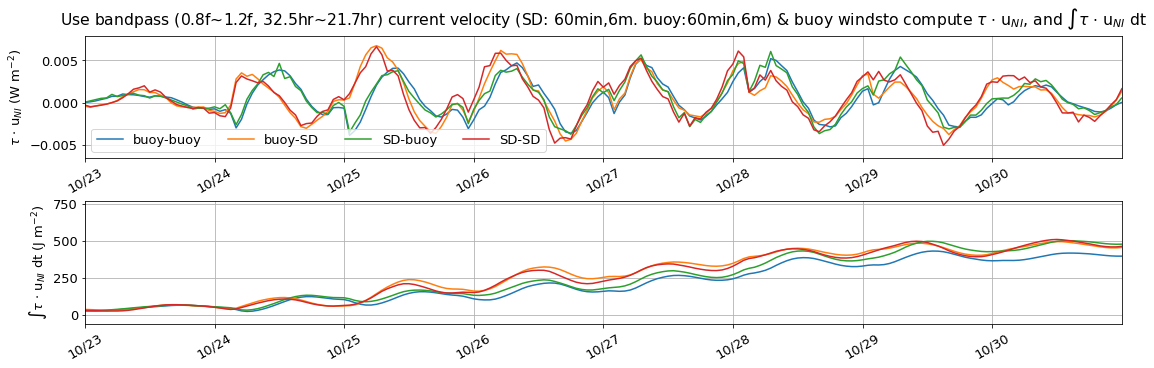

In [17]:
### plot wind power (tau dot NI current velocity in W m^-2) and energy input (integrate wind power over time in J m^-2)
nrow = 2
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
### wind power
plt.subplot(nrow,1,1)
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_buoywnd_buoycur, label='buoy-buoy')
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_buoywnd_SDcur, label='buoy-SD')
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_SDwnd_buoycur, label='SD-buoy')
plt.plot( dtime_buoy_grid, tau_dot_sfcvel_SDwnd_SDcur, label='SD-SD')
plt.legend(ncol=4, loc='best')
plt.ylabel('$\u03C4$ $\cdot$ u$_{NI}$ (W m$^{-2}$)')
### energy input
plt.subplot(nrow,1,2)
plt.plot( dtime_buoy_grid, energy_input_buoywnd_buoycur, label='buoy-buoy')
plt.plot( dtime_buoy_grid, energy_input_buoywnd_SDcur, label='buoy-SD')
plt.plot( dtime_buoy_grid, energy_input_SDwnd_buoycur, label='SD-buoy')
plt.plot( dtime_buoy_grid, energy_input_SDwnd_SDcur, label='SD-SD')
plt.ylabel('$\int$$\u03C4$ $\cdot$ u$_{NI}$ dt (J m$^{-2}$)')
### figure setting
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()

plt.suptitle('Use bandpass ({:.1f}f~{:.1f}f, {:.1f}hr~{:.1f}hr) current velocity (SD: {:.0f}min,{:.0f}m. buoy:{:.0f}min,{:.0f}m) & buoy winds'.\
             format(n_f[0],n_f[1],bp_sec[0]/3600,bp_sec[1]/3600,dsec_buoy/60,6,dsec_buoy/60,6)+\
                'to compute $\u03C4$ $\cdot$ u$_{NI}$, and $\int$$\u03C4$ $\cdot$ u$_{NI}$ dt')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save figure
plt.savefig('timeseries_wind-power_energy-input(SD-buoy-combination)_bp({:.1f}f~{:.1f}f)_'.format(n_f[0],n_f[1])+\
            platf_num+'({:.1f}m)'.format(6)+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(6)+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_from-buoy-cur-grid.png',dpi=400,bbox_inches='tight')

In [ ]:
tlim_check = [datetime.datetime(int(year),10,30),datetime.datetime(int(year),10,31)]
it = np.where( (dtime_buoy_grid>= tlim_check[0]) & (dtime_buoy_grid<= tlim_check[1]) )[0]
res = []
platforms = ['SD','buoy']
print(tlim_check)
for i in range( len(platforms) ):
    for j in range( len(platforms) ):
        mn = np.mean( eval('energy_input_'+platforms[i]+'wnd_'+platforms[j]+'cur[it]') )
        res.append(mn)
        print(platforms[i],'wind dot',platforms[j],'current - mean energy input = {:.2f} (J/m^2)'.format(mn))

[datetime.datetime(2023, 10, 30, 0, 0), datetime.datetime(2023, 10, 31, 0, 0)]
SD wind dot SD current - mean energy input = 471.21 (J/m^2)
SD wind dot buoy current - mean energy input = 470.65 (J/m^2)
buoy wind dot SD current - mean energy input = 464.57 (J/m^2)
buoy wind dot buoy current - mean energy input = 393.95 (J/m^2)
